## Dataset: http://ai.stanford.edu/~amaas/data/sentiment/

O dataset consiste num conjunto de reviews de filmes do IMBD e o modelo vai ter como objetivo classificar as revies em **positivas** ou **negativas**.

## Setup

In [1]:
import tensorflow as tf

!pip install -q tensorflow-datasets
from tensorflow import keras
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np

print(tf.__version__)

2.0.0


Este dataset já foi preprocessado de maneira a que as reviews (sequências de palavras) já foram convertidas numa sequência de inteiros, em que cada inteiro representa uma palavra específica no dicionário 

In [2]:

(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

## Encoder

 The dataset `info` includes the text encoder (a `tfds.features.text.SubwordTextEncoder`).
 
 Abstract base class for converting between text and integers.
 
 https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder

In [3]:
encoder = info.features['text'].encoder
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


Este text encoder codifica reversivelmente qualquer string:

In [4]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [5]:
for ts in encoded_string:
  print ('{} ----> {}'.format(ts, encoder.decode([ts])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## Explore the data

Cada label é um inteiro (0 ou 1), onde 0 é uma review **negativa** e 1 é uma review **positiva**.

Exemplo: 1ª Review

In [17]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:20].numpy())
  print('Label:', train_label.numpy())



Encoded text: [ 249    4  277  309  560    6 6639 4574    2   12   31 7759 3525 2128
   93 2306   43 2312 2527    6]
Label: 1


In [7]:
# Para comprovar que a crítica é facto negativa.
encoder.decode(train_example[:100])

'As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious '

## Prepare the data for training

É necessário criar 'batches of training data' para alimentar o modelo deforma a uniformizar os tamanhos das reviews, usando: `padded_batch`(This transformation combines multiple consecutive elements of the input dataset into a single element) to zero pad the sequences while batching:

In [8]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, train_data.output_shapes))

test_batches = (
    test_data
    .padded_batch(32, train_data.output_shapes))

Each batch will have a shape of `(batch_size, sequence_length)` because the padding is dynamic each batch will have a different length.

## Build the model


In [9]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

### Hidden units

Este modelo tem duas camadas intermediárias ou "ocultas", entre o input e o output. O número de outputs (unidades, nós ou neurónios) é a dimensão do espaço representacional da camada. Ou seja, *the amount of freedom* que a rede têm ao aprender uma representação interna.

Se um modelo tiver mais *hidden units* (um espaço de representação de maior dimensão) e/ou mais camadas, a rede poderá aprender representações mais complexas. No entanto, torna a rede mais cara em termos de computação e pode levar à aprendizagem de padrões indesejados - padrões que melhoram o desempenho nos dados de treino, mas não nos dados de teste. Isso é chamado de overfitting.



### Loss function and optimizer

Como se trata de um problema com classificação binária e o modelo dá como output uma probabilidade (*sigmoid activation*), usaremos a função de *loss* `binary_crossentropy`.

Não é a unica escolha possível , seria possível usar também o `mean_squared_error`. Mas geralmente `binary_crossentropy` é melhor para lidar com probabilidades pois "mede" a distância entre as distribuições de probabilidade, neste caso, entre  a distribuição real e as previsões.

https://medium.com/ai%C2%B3-theory-practice-business/adam-optimization-algorithm-in-deep-learning-9b775dacbc9f


In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the model

Train the model by passing the `Dataset` object to the model's fit function. Set the number of epochs.

In [11]:
history = model.fit(train_batches,
                    epochs=10,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 27s 35ms/step - loss: 0.6816 - accuracy: 0.6249 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
782/782 [==============================] - 21s 26ms/step - loss: 0.6195 - accuracy: 0.7549 - val_loss: 0.5917 - val_accuracy: 0.7906
Epoch 3/10
782/782 [==============================] - 30s 38ms/step - loss: 0.5400 - accuracy: 0.8094 - val_loss: 0.5259 - val_accuracy: 0.8208
Epoch 4/10
782/782 [==============================] - 28s 36ms/step - loss: 0.4707 - accuracy: 0.8410 - val_loss: 0.4728 - val_accuracy: 0.8521
Epoch 5/10
782/782 [==============================] - 27s 35ms/step - loss: 0.4214 - accuracy: 0.8624 - val_loss: 0.4324 - val_accuracy: 0.8562
Epoch 6/10
782/782 [==============================] - 22s 28ms/step - loss: 0.3802 - accuracy: 0.8782 - val_loss: 0.3998 - val_accuracy: 0.8635
Epoch 7/10
782/782 [==============================] - 23s 30ms/step - loss: 0.3484 - accuracy: 0.8858 - val_loss: 0.3751 - val_a

## Evaluate the model

And let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [12]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 15s 19ms/step - loss: 0.3319 - accuracy: 0.8766 - 11s 20ms/step - loss: - 12s 20ms/
Loss:  0.3318539673695936
Accuracy:  0.87656


## Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [13]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Existem quatro entradas: uma para cada métrica monitorizada durante o treino e a validação. 


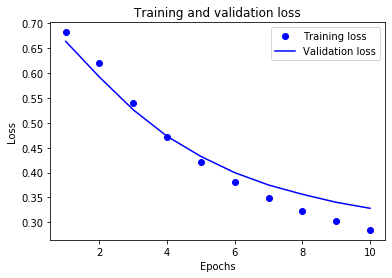

In [16]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

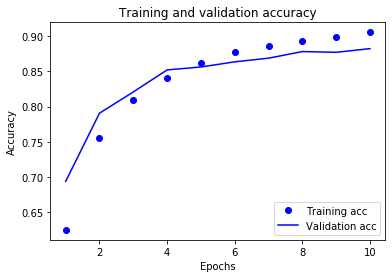

In [15]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Neste gráfico, os pontos representam a *loss* e a *accuracy* do treino, e as linhas são a *loss* e a *accuracy* da validação.

É possível verificar que que a *loss* do treino diminui a cada iteração e a *accuracy* do treino aumenta a cada iteração. Isso é esperado ao usar uma otimização *gradient descent* - que minimiza o valor desejado a cada iteração.

Mas não é o caso da *loss* e *accuracy* da validação - estas atigem o pico após cerca de vinte *epochs*. Este é um exemplo de *overfitting*: o modelo tem melhor desempenho nos dados de treio do que nos dados que nunca viu antes. Após esse ponto, o modelo otimiza demais e aprende representações específicas para os dados de treino que não generalizam  para testar dados.

Nesse caso em particular, poderíamos evitar o *overfitting* simplesmente interrompendo o treino. 